<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
%run -i experiments_common.py

In [370]:
df

,Features,Num_models_per_system_per_fold,Num_test_per_fold,Num_train_per_fold,Perfmeasure,Scope,Scope_detail,accuracy_DRMM,accuracy_MP_COS,accuracy_PACRR_DRMM,accuracy_bm25,accuracy_pl2,accuracy_tf_idf,Feat_desc
loc_q,"[ax_AND, ax_DIV, ax_LB1, ax_LNC1, ax_M_AND, ax...",100,1279.000000,8943.179688,10-fold cv accuracy,Local,query,0.682557,0.665273,0.721414,0.745739,0.783077,0.660380,ax
loc_rd,"[ax_AND, ax_DIV, ax_LB1, ax_LNC1, ax_M_AND, ax...",24,4379.533203,38212.882812,10-fold cv accuracy,Local,rank-diff bin,0.612381,0.588034,0.672911,0.712827,0.773488,0.632984,ax
loc_sd,"[ax_AND, ax_DIV, ax_LB1, ax_LNC1, ax_M_AND, ax...",24,4265.375000,38327.042969,10-fold cv accuracy,Local,score-diff bin,0.614908,0.591266,0.676232,0.716099,0.779498,0.636457,ax
loc_q_rd,"[ax_AND, ax_DIV, ax_LB1, ax_LNC1, ax_M_AND, ax...",2368,43.661316,383.552368,10-fold cv accuracy,Local,"query, rank-diff bin",0.662737,0.645917,0.698099,0.726894,0.768775,0.638321,ax
loc_q_sd,"[ax_AND, ax_DIV, ax_LB1, ax_LNC1, ax_M_AND, ax...",2394,43.596493,383.380127,10-fold cv accuracy,Local,"query, score-diff bin",0.661848,0.644754,0.702316,0.737761,0.786836,0.653245,ax


In [220]:

abbrev = dict(
    rankdiff='rd',
    scorediff='sd',
    upper_rank='ur',
    upper_score='us'
)

def featdesc(arr):
    arr = set(arr)
    d = []
    if default_axioms.issubset(arr):
        d.append('ax')
        arr.difference_update(default_axioms)
    if arr:
        d.extend(abbrev[x] for x in sorted(arr))
    return '+'.join(d)
    

def read_json(file_name):
    ret = pd.read_json(file_name)
    ret['Feat_desc'] = df.Features.map(featdesc)
    i = ret.index
    ret = ret.reindex(index=sorted(i, key=lambda x: (0 if 'glo' in x else 2 if '+' in x else 1, x.count('_'), x.count('+'), x)))
    
    return ret

In [224]:
jsonl_file = 'robust-04-new-explanations-fidelity-summary.jsonl'

df = read_json(jsonl_file)
df_ms_marco = read_json('ms-marco-explanations-fidelity-summary.jsonl')

default_axioms = set(df.Features.values[0])

In [20]:
#system_order_ms_marco = ['ms_marco_bm25', 'ms_marco_tf_idf', 'ms_marco_pl2', 'ms_marco_dai_maxp', 'ms_marco_qa_maxp', 'ms_marco_jlin']
system_order_ms_marco = ['ms_marco_bm25', 'ms_marco_tf_idf', 'ms_marco_pl2', 'ms_marco_jlin', 'ms_marco_dai_maxp']
system_order_robust04 = ['bm25', 'tf_idf', 'pl2', 'MP_COS', 'DRMM', 'PACRR_DRMM']

system_display_values = {
    'ms_marco_bm25': 'BM25',
    'ms_marco_tf_idf': 'TF-IDF',
    'ms_marco_pl2': 'PL2',
    'ms_marco_dai_maxp': 'DAI-MAXP',
    'ms_marco_qa_maxp': 'QA-MAXP',
    'ms_marco_jlin': 'BERT-3S',
    'DRMM': 'DRMM',
    'MP_COS': 'MP-COS',
    'PACRR_DRMM': 'PACRR-DRMM',
    'bm25': 'BM25',
    'pl2': 'PL2',
    'tf_idf': 'TF-IDF'
}


def format_acc(df ,r, k):
    is_top = r[k] == df[k].max()
    prefix = r"\bfseries " if is_top else ""
    return f'{prefix}{r[k]:.2f}'
    
def row2latex(df, r, order):
    return f"""
    {r.Scope_detail} &
    {r.Num_models_per_system_per_fold:,d} & \\scriptsize {r.Num_train_per_fold:,.0f} & \\scriptsize {r.Num_test_per_fold:,.0f} &
    {' & '.join(format_acc(df, r, f'accuracy_{s}') for s in order)} &
    {r.Perfmeasure.replace(' accuracy', '')}
    """.replace('\n', ' ').strip()

from io import StringIO

buf = StringIO()


buf.write(r"""
\begin{tabular}{@{}lrrrrrrrrrr@{}}

\toprule
\bfseries Model scope &  \bfseries Models & \multicolumn{2}{c}{\bfseries Samples/model} & \multicolumn{6}{c}{\bfseries Explanation Accuracy} & \bfseries Acc. via \\
& {\scriptsize\bfseries (per system)} & \bfseries\scriptsize Train & \bfseries\scriptsize Test & \multicolumn{3}{c}{\bfseries\scriptsize Classical Models} & \multicolumn{3}{c}{\bfseries\scriptsize Neural Models} \\
%\midrule
%\multicolumn{9}{@{}l}{\emph{Global models}}\\
""")
buf.write('\n')

inLoc = False

for _, r in df.iterrows():
    if not inLoc and r.Scope == 'Local':
        inLoc = True
        buf.write('\\midrule\n\multicolumn{5}{@{}l}{\\emph{Robust04}} \\bfseries\\scriptsize ' + (' & \\bfseries\\scriptsize '.join(system_display_values[x].replace("_", "-") for x in system_order_robust04)) + '\\\\\n')
    buf.write(row2latex(df, r, system_order_robust04))
    buf.write('\\\\\n')
    
inLoc = False
for _, r in df_ms_marco.iterrows():
    if not inLoc and r.Scope == 'Local':
        inLoc = True
        buf.write('\\midrule\n\multicolumn{5}{@{}l}{\\emph{MS-MARCO}} \\bfseries\\scriptsize ' + (' & \\bfseries\\scriptsize '.join(system_display_values[x].replace("_", "-") for x in system_order_ms_marco)) + '\\\\\n')
    buf.write(row2latex(df_ms_marco, r, system_order_ms_marco))
    buf.write('\\\\\n')
buf.write('\\bottomrule\n\end{tabular}\n')

print(buf.getvalue())

NameError: name 'df' is not defined

In [198]:
from multiprocessing.dummy import Pool
p = Pool(100)
p.map(lambda x: x, range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Plots for MS-MARCO

In [2]:
%run -i experiments_common.py

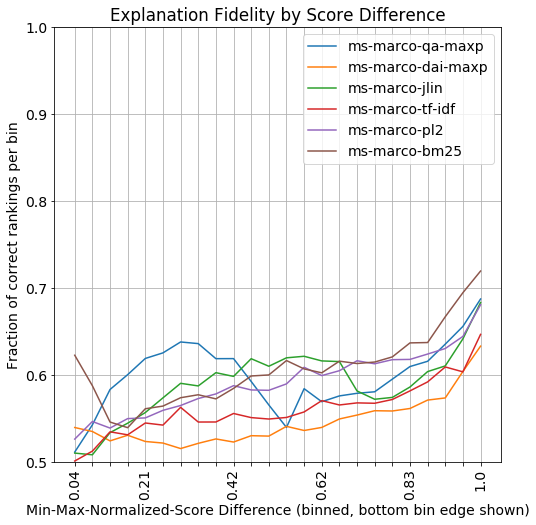

In [7]:
import json

loc_sd = json.load(open('ms-marco-loc_sd.json'))
SCORE_DIFF_LABELS =  ['0.04', '', '', '', '0.21', '', '', '', '', '0.42', '', '', '', '', '0.62', '', '', '', '', '0.83', '', '', '', '1.0']

sns.lineplot(data=json.loads(loc_sd['data']), x='scorediff_bin', y='cv_accuracy_mean', hue='system')
bin_labels = loc_sd['bin_labels']
plt.xticks(np.arange(len(bin_labels)), SCORE_DIFF_LABELS, rotation=90)
plt.xlabel('Min-Max-Normalized-Score Difference (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Explanation Fidelity by Score Difference')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();

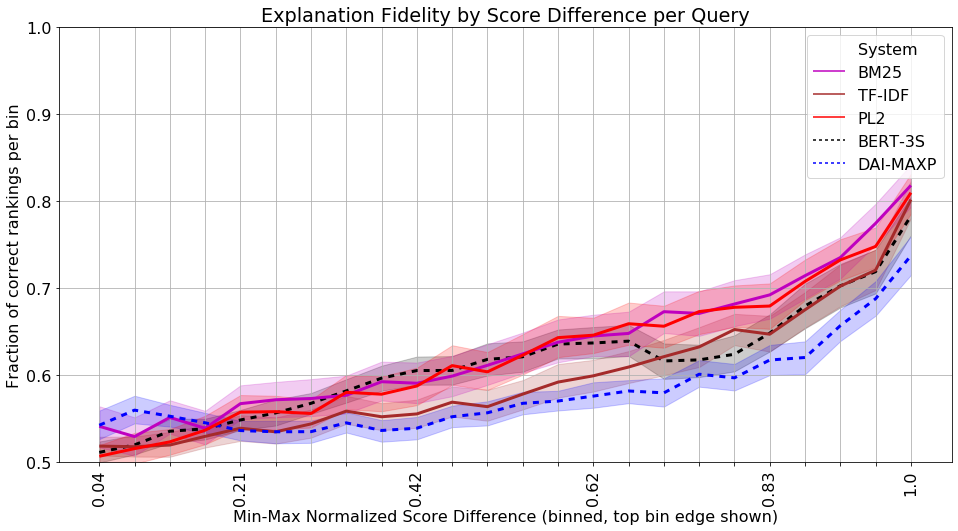

In [86]:
from cycler import cycler
import json
loc_q_sd = json.load(open('ms-marco-loc_q_sd.json'))


plt.rcParams.update({'font.size': 16})
#plt.rcParams['axes.prop_cycle'] = cycler(color='gkcbr')
#plt.rcParams['axes.prop_cycle'] =  (cycler(color=['c', 'm', 'y', 'k', 'r', 'b']) +
#                  cycler(lw=[3, 3, 3, 3, 3, 3]) +cycler(linestyle=['-', '--', '-', '--', '-', '--',])

#plt.rcParams['axes.prop_cycle'] = {}

PALETTE = {'BM25': 'm', 'PL2': 'r', 'PACRR-DRMM': 'c', 'MP-COS': 'b', 'DRMM': 'k', 'TF-IDF': 'brown', 'DAI-MAXP': 'b', 'BERT-3S': 'k'}
DASHES = {'BM25': (1, 0), 'TF-IDF': (1, 0), 'PL2': (1, 0), 'BERT-3S': (2, 2), 'DAI-MAXP': (2, 2), 'PACRR-DRMM': (2, 2), 'MP-COS': (2, 2), 'DRMM': (2, 2)}

bla = pd.read_json(loc_q_sd['data'])
bla = bla[(bla.system != 'ms-marco-qa-maxp')]
bla['System'] = bla.system.map(lambda i: system_display_values[i.replace('-', '_')])


sns.lineplot(data=bla, x='scorediff_bin', y='cv_accuracy_mean', dashes=DASHES, palette=PALETTE, lw=3, style='System', hue='System')
bin_labels = loc_q_sd['bin_labels']
plt.xticks(np.arange(len(bin_labels)), SCORE_DIFF_LABELS, rotation=90)
plt.xlabel('Min-Max Normalized Score Difference (binned, top bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Explanation Fidelity by Score Difference per Query')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((16,8))

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 3, 2, 5, 1, 4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.grid();
plt.savefig('figure-score-diff-explainability-ms-marco.pdf', bbox_inches='tight')


# Plots for Robust04

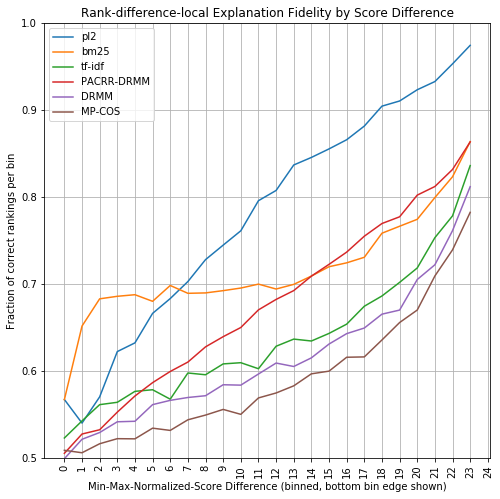

In [13]:
loc_sd = json.load(open('robust04-loc_sd.json'))

sns.lineplot(data=json.loads(loc_sd['data']), x='scorediff_bin', y='cv_accuracy_mean', hue='system')
bin_labels = loc_sd['bin_labels']
plt.xticks(np.arange(len(bin_labels)), range(0, len(bin_labels)), rotation=90)
plt.xlabel('Min-Max-Normalized-Score Difference (binned, bottom bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Rank-difference-local Explanation Fidelity by Score Difference')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((8,8))
plt.grid();

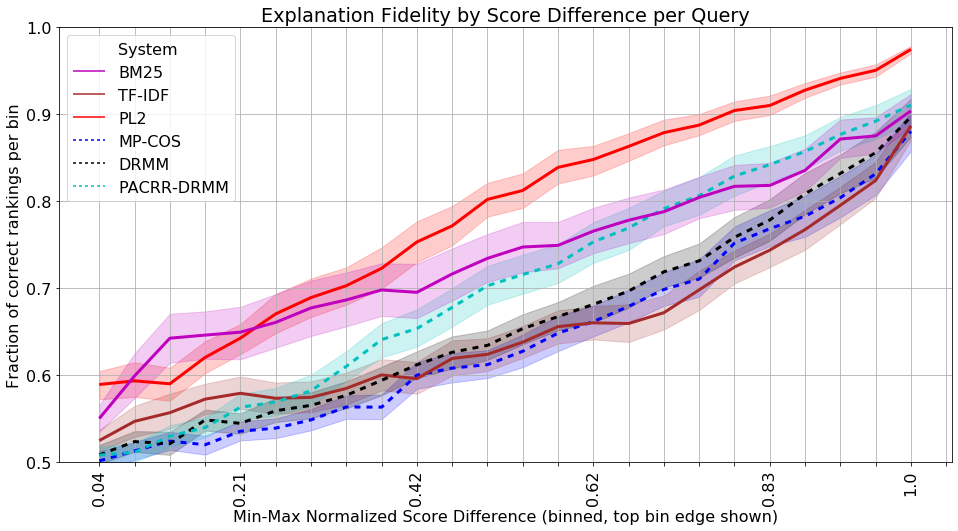

In [88]:
loc_q_sd = json.load(open('robust04-loc_q_sd.json'))

plt.rcParams.update({'font.size': 16})

style = {
    'ms_marco_bm25': 'red dashed',
    'ms_marco_tf_idf': 'yellow dashed',
    'ms_marco_pl2': 'PL2',
    'ms_marco_dai_maxp': 'DAI-MAXP',
    'ms_marco_qa_maxp': 'QA-MAXP',
    'ms_marco_jlin': 'BERT-3S',
    'DRMM': 'DRMM',
    'MP_COS': '+',
    'PACRR_DRMM': '-',
    'bm25': 'red dashed',
    'pl2': '+',
    'tf_idf': 'yellow dashedF'
}

bla = pd.read_json(loc_q_sd['data'])
bla['System'] = bla.system.map(lambda i: system_display_values[i.replace('-', '_')])
bla['style'] = bla.system.map(lambda i: style[i.replace('-', '_')])



sns.lineplot(data=bla, x='scorediff_bin', y='cv_accuracy_mean', dashes=DASHES, lw=3, style='System', palette=PALETTE, hue='System')
bin_labels = loc_q_sd['bin_labels']
plt.xticks(np.arange(len(bin_labels)), SCORE_DIFF_LABELS, rotation=90)
plt.xlabel('Min-Max Normalized Score Difference (binned, top bin edge shown)')
plt.ylabel('Fraction of correct rankings per bin')
plt.title('Explanation Fidelity by Score Difference per Query')
plt.ylim((0.5,1));
plt.gcf().set_size_inches((16,8))
plt.gca().set_prop_cycle(cycler(color='gm'))
plt.grid();

handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 6, 2, 3, 1, 4, 5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.savefig('figure-score-diff-explainability-robust04.pdf', bbox_inches='tight')


In [235]:
d = json.loads(json.load(open('robust04-loc_q_sd.json'))['data'])
d.keys()

#d.feature_importances = d['feature_importances']
d = pd.read_json(json.load(open('robust04-loc_q_sd.json'))['data'])

In [404]:
def mean_axiom_weights(df, features=list(['ax_AND', 'ax_DIV', 'ax_LB1', 'ax_LNC1', 'ax_M_AND', 'ax_M_TDC', 'ax_PROX1', 'ax_PROX2', 'ax_PROX3', 'ax_PROX4', 'ax_PROX5', 'ax_REG', 'ax_STMC1', 'ax_STMC1_f', 'ax_STMC1_fr', 'ax_STMC2', 'ax_STMC2_f', 'ax_STMC2_fr', 'ax_TFC1', 'ax_TFC3', 'ax_TF_LNC'])):
    s = df.feature_importances.map(lambda a: dict(zip(features, a)))
    s = pd.DataFrame(list(s))
    
    return sorted([(ax, ax_importances.mean()) for ax, ax_importances in s.iteritems()], key=lambda i: i[1], reverse=True)

def feature_importance_per_score_diff():
    TOP_RESULTS = 3
    ret = {'tiny-changes': {}, 'small-changes': {}, 'medium-changes': {}, 'large-changes': {}}
    
    for model in ['bm25', 'tf-idf', 'pl2', 'MP-COS', 'DRMM', 'PACRR-DRMM']:
        model = model.replace('_', '-')
        tmp_d = d[(d.system == model) & (d.scorediff_bin <= 2)]
        ret['tiny-changes'][model] = mean_axiom_weights(tmp_d)[:TOP_RESULTS]

        tmp_d = d[(d.system == model) & (d.scorediff_bin > 2) & (d.scorediff_bin <= 6)]
        ret['small-changes'][model] = mean_axiom_weights(tmp_d)[:TOP_RESULTS]

        tmp_d = d[(d.system == model) & (d.scorediff_bin > 6) & (d.scorediff_bin <= 12)]
        ret['medium-changes'][model] = mean_axiom_weights(tmp_d)[:TOP_RESULTS]

        tmp_d = d[(d.system == model) & (d.scorediff_bin > 12)]
        ret['large-changes'][model] = mean_axiom_weights(tmp_d)[:TOP_RESULTS]
    
    return ret

def distinct_axioms(fimp_for_type):
    axiom_to_position = {'ax_REG': 0, 'ax_PROX4': 1, 'ax_PROX5': 2, 'ax_LNC1': 3, 'ax_DIV': 4, 'ax_STMC1_f': 5, 'ax_STMC1_fr': 6, 'ax_LB1': 7}
    ret = []
    for bla in [fimp_for_type[model] for model in fimp_for_type]:
        ret += [i[0] for i in bla]

    return sorted([i for i in set(ret)], key=lambda i: axiom_to_position[i])

def fimp_table():
    fimp = feature_importance_per_score_diff()
    SIZE = '\\tiny'
    table_columns = '{@{}l' 
    header = ''
    sub_header = '\n'
    for change_type in fimp:
        fimp_for_type = fimp[change_type]
        axioms_within_change_type = distinct_axioms(fimp_for_type)
        table_columns += (''.join('r' for i in range(len(axioms_within_change_type))))
        table_columns += '' if change_type == 'large-changes' else '@{\hskip 0.22in}'
        
        header += '&\\multicolumn{' + str(len(axioms_within_change_type)) + '}{c}{\\bfseries ' + change_type + '} '
        for ax in axioms_within_change_type:
            sub_header += ' & {'+ SIZE +'\\bfseries ' + ax.replace('ax_', '').replace('_', '-') + '} '
    
    table_rows = '\n\n'
    for model in  ['bm25', 'tf-idf', 'pl2', 'MP-COS', 'DRMM', 'PACRR-DRMM']:
        table_rows += '\\bfseries \\scriptsize ' + model.replace('_', '-').replace('PACRR-DRMM', 'PACRR')
        for change_type in fimp:
            for ax in distinct_axioms(fimp[change_type]):
                val = {i[0]: i[1] for i in fimp[change_type][model]}
                
                if ax in val:
                    table_rows += ' & ' + SIZE + f' {val[ax]:.2f}'
                else:
                    table_rows += ' & '
        
        table_rows += '\\\\\n'
    table_rows += '\n\n'
    cmidrule = '\cmidrule(r@{1.5em}){2-6}\n\cmidrule(r@{1em}){7-10}\n\cmidrule(r@{1em}){11-15}\n\cmidrule(r@{0.1em}){16-21}\n'
    table_columns += '@{}}'
    print('\\begin{tabular}' + table_columns + '\n\\toprule\n' + header + ' \\\\\n ' + cmidrule + sub_header +'\\\\\n\midrule  ' + table_rows + '\\bottomrule\n\\end{tabular}')

fimp_table()

\begin{tabular}{@{}lrrrrr@{\hskip 0.22in}rrrr@{\hskip 0.22in}rrrrr@{\hskip 0.22in}rrrrrr@{}}
\toprule
&\multicolumn{5}{c}{\bfseries tiny-changes} &\multicolumn{4}{c}{\bfseries small-changes} &\multicolumn{5}{c}{\bfseries medium-changes} &\multicolumn{6}{c}{\bfseries large-changes}  \\
 \cmidrule(r@{1.5em}){2-6}
\cmidrule(r@{1em}){7-10}
\cmidrule(r@{1em}){11-15}
\cmidrule(r@{0.1em}){16-21}

 & {\tiny\bfseries REG}  & {\tiny\bfseries PROX4}  & {\tiny\bfseries LNC1}  & {\tiny\bfseries DIV}  & {\tiny\bfseries LB1}  & {\tiny\bfseries REG}  & {\tiny\bfseries PROX4}  & {\tiny\bfseries LNC1}  & {\tiny\bfseries DIV}  & {\tiny\bfseries REG}  & {\tiny\bfseries PROX4}  & {\tiny\bfseries PROX5}  & {\tiny\bfseries LNC1}  & {\tiny\bfseries DIV}  & {\tiny\bfseries REG}  & {\tiny\bfseries PROX4}  & {\tiny\bfseries PROX5}  & {\tiny\bfseries DIV}  & {\tiny\bfseries STMC1-f}  & {\tiny\bfseries STMC1-fr} \\
\midrule  

\bfseries \scriptsize bm25 & \tiny 0.14 & \tiny 0.13 & \tiny 0.17 &  &  & \tiny 0.16 & \

In [381]:
d

,query,system,scorediff_bin,cv_accuracy_mean,cv_accuracy_std,avg_train_samples_per_fold,avg_test_samples_per_fold,feature_importances
0,301,MP-COS,14,0.545833,0.089753,420,48,"[0.0, 0.0932576677, 0.0, 0.0073972969, 0.0, 0...."
1,301,tf-idf,1,0.465789,0.086523,326,38,"[0.0, 0.0812670548, 0.1076488755, 0.0, 0.0, 0...."
10,321,pl2,20,0.910000,0.059722,256,30,"[0.0, 0.1974128964, 0.0, 0.0452483241, 0.0, 0...."
100,359,DRMM,1,0.486111,0.142319,322,36,"[0.0, 0.10791368, 0.050203094600000005, 0.0308..."
1000,397,MP-COS,1,0.567647,0.075043,596,68,"[0.0, 0.1873561032, 0.1486001209, 0.0897317739..."
10000,427,pl2,8,0.620833,0.099391,200,24,"[0.0, 0.09139575, 0.0371691232, 0.089504963, 0..."
10001,433,PACRR-DRMM,13,0.851923,0.075980,450,52,"[0.0, 0.1234492955, 0.0, 0.024055311700000002,..."
10002,435,bm25,23,0.826316,0.075541,324,38,"[0.0, 0.0582061596, 0.0, 0.0, 0.0, 0.0, 0.0360..."
10003,436,PACRR-DRMM,14,0.775000,0.112361,352,40,"[0.0, 0.23189484, 0.0, 0.015281896500000001, 0..."
10004,436,tf-idf,15,0.564583,0.103937,428,48,"[0.0, 0.15764607660000002, 0.0, 0.1442107913, ..."


In [252]:
sorted([(ax, ax_importances.mean()) for ax, ax_importances in tmp_test.iteritems()], key=lambda tup: tup[1], reverse=True)[:5]

[('ax_LNC1', 0.188061488077),
 ('ax_REG', 0.13360672912),
 ('ax_PROX4', 0.132855867294),
 ('ax_DIV', 0.092712514931),
 ('ax_LB1', 0.07514325659500001)]

       query system  scorediff_bin  cv_accuracy_mean  cv_accuracy_std  \
0        NaN    NaN            NaN               NaN              NaN   
1        NaN    NaN            NaN               NaN              NaN   
2        NaN    NaN            NaN               NaN              NaN   
3        NaN    NaN            NaN               NaN              NaN   
4        NaN    NaN            NaN               NaN              NaN   
5        NaN    NaN            NaN               NaN              NaN   
6        NaN    NaN            NaN               NaN              NaN   
7        NaN    NaN            NaN               NaN              NaN   
8        NaN    NaN            NaN               NaN              NaN   
9        NaN    NaN            NaN               NaN              NaN   
10       NaN    NaN            NaN               NaN              NaN   
11       NaN    NaN            NaN               NaN              NaN   
12       NaN    NaN            NaN               Na

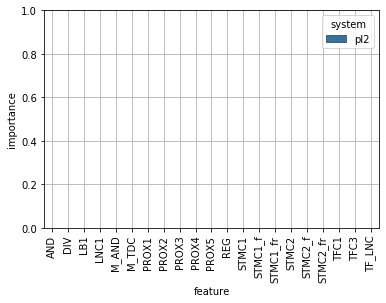

In [150]:
query_system_scorediff = ['query', 'system', 'scorediff_bin']

def feature_importances(df, group_key, features=list(['ax_AND', 'ax_DIV', 'ax_LB1', 'ax_LNC1', 'ax_M_AND', 'ax_M_TDC', 'ax_PROX1', 'ax_PROX2', 'ax_PROX3', 'ax_PROX4', 'ax_PROX5', 'ax_REG', 'ax_STMC1', 'ax_STMC1_f', 'ax_STMC1_fr', 'ax_STMC2', 'ax_STMC2_f', 'ax_STMC2_fr', 'ax_TFC1', 'ax_TFC3', 'ax_TF_LNC'])):
    s = df.feature_importances.map(lambda a: dict(zip(features, a)))
    
    s = pd.DataFrame(list(s))
    s = pd.concat([df, s], axis=1)
    print(s)
    s = s.melt(id_vars=group_key, value_vars=features, var_name='feature', value_name='importance')
    s['feature'] = s.feature.map(lambda fname: fname.replace('ax_', ''))
    
    return s

bin = 20
bin = 3
system = 'pl2'
bla = d[(d.system == 'pl2') & (d.scorediff_bin == bin)]
qsdm_fimp = feature_importances(bla, query_system_scorediff)
qsdm_fimp = qsdm_fimp[(qsdm_fimp.system == system ) & (qsdm_fimp.scorediff_bin == bin)]
p = sns.boxenplot(data=qsdm_fimp, x='feature', y='importance', hue='system')
p.set_xticklabels(p.get_xticklabels(), rotation=90);
plt.grid()
#qsdm_fimp[(qsdm_fimp.feature == 'DIV')]

In [64]:
d[(d.system == 'bm25') & (d.scorediff_bin == 2)]

,query,system,scorediff_bin,cv_accuracy_mean,cv_accuracy_std,avg_train_samples_per_fold,avg_test_samples_per_fold,feature_importances
10125,393,bm25,2,0.842500,0.058149,350,40,"[0.0, 0.0562831611, 0.026760981700000002, 0.67..."
10393,325,bm25,2,0.658824,0.150086,298,34,"[0.0, 0.0559954464, 0.0697484919, 0.5535540584..."
10469,306,bm25,2,0.630000,0.122429,254,30,"[0.0, 0.10809748370000001, 0.09780707350000001..."
10703,324,bm25,2,0.775000,0.125277,206,24,"[0.0, 0.1407984321, 0.07722354470000001, 0.285..."
10851,351,bm25,2,0.734615,0.063082,222,26,"[0.0, 0.0701719987, 0.0978744445, 0.2746879869..."
10903,323,bm25,2,0.683333,0.072173,594,66,"[0.0, 0.10145975800000001, 0.1010487397, 0.291..."
10935,409,bm25,2,0.707500,0.080661,346,40,"[0.0, 0.0995701088, 0.1219161156, 0.0452349975..."
10968,310,bm25,2,0.648438,0.060212,570,64,"[0.0, 0.10495700720000001, 0.1548752903, 0.041..."
11014,408,bm25,2,0.689130,0.074708,408,46,"[0.0, 0.0731311858, 0.1043157004, 0.3719694576..."
11450,611,bm25,2,0.619231,0.125752,234,26,"[0.0, 0.0900092885, 0.1003650277, 0.2053869559..."


In [51]:
str(bytes(int(1)))

"b'\\x00'"